# Imports

In [ ]:
# Install tpot on the server
!pip install tpot

In [ ]:
#  General
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Utility
from scipy import stats
from scipy.stats import norm
from sklearn.pipeline import make_pipeline
import warnings
from itertools import cycle

# Preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import learning_curve,ShuffleSplit,validation_curve, train_test_split
from sklearn.model_selection import GridSearchCV,learning_curve
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score, cross_validate, KFold

# Models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from tpot import TPOTClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier


# Metrics
from sklearn.metrics import classification_report, confusion_matrix,f1_score,make_scorer,accuracy_score,roc_curve, auc, accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer, accuracy_score

# Graphs
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from mlxtend.plotting import plot_decision_regions


warnings.filterwarnings('ignore')
%matplotlib inline

# Retrieve dataset

In [ ]:
DS_URL = "https://raw.githubusercontent.com/clintonyeb/ml-dataset/master/BEPS.csv"
FIG_SIZE=(12, 6)

In [ ]:
beps = pd.read_csv(DS_URL, names=["id", "vote", "age", "nat_cond", "hhold_cond", "labor_lead_assmnt", "cons_lead_assmnt", "democ_lead_assmnt", "euro_intg_attud", "political_knowledge", "gender"], index_col="id", header=0)
beps.head(10)

,vote,age,nat_cond,hhold_cond,labor_lead_assmnt,cons_lead_assmnt,democ_lead_assmnt,euro_intg_attud,political_knowledge,gender
id,,,,,,,,,,
1,Liberal Democrat,43,3,3,4,1,4,2,2,female
2,Labour,36,4,4,4,4,4,5,2,male
3,Labour,35,4,4,5,2,3,3,2,male
4,Labour,24,4,2,2,1,3,4,0,female
5,Labour,41,2,2,1,1,4,6,2,male
6,Labour,47,3,4,4,4,2,4,2,male
7,Liberal Democrat,57,2,2,4,4,2,11,2,male
8,Labour,77,3,4,4,1,4,1,0,male
9,Labour,39,3,3,4,4,4,11,0,female


# Exploratory Data Analysis (EDA)

We are using [British Election Panel Study](https:/https://vincentarelbundock.github.io/Rdatasets/doc/carData/BEPS.html/) dataset.    

<font size = "4"><u>***Description***</u></font>   
These data are drawn from the 1997-2001 British Election Panel Study (BEPS).   

---

<font size = "4"><u>***Format***</u></font>      
A data frame with 1525 observations on the following 10 variables.   

**vote** (vote)   
Party choice: Conservative, Labour, or Liberal Democrat

**age** (age)   
in years

**economic.cond.national** (nat_cond)   
Assessment of current national economic conditions, 1 to 5.

**economic.cond.household** (hhold_cond)   
Assessment of current household economic conditions, 1 to 5.

**Blair** (labor_lead_assmnt)   
Assessment of the Labour leader, 1 to 5.

**Hague** (cons_lead_assmnt)   
Assessment of the Conservative leader, 1 to 5.

**Kennedy** (democ_lead_assmnt)   
Assessment of the leader of the Liberal Democrats, 1 to 5.

**Europe** (euro_intg_attud)   
an 11-point scale that measures respondents' attitudes toward European integration. High scores represent ‘Eurosceptic’ sentiment.

**political.knowledge** (political_knowledge)   
Knowledge of parties' positions on European integration, 0 to 3.

**gender** (gender)   
female or male.

---

<font size = "4"><u>***References***</u></font>   
J. Fox and R. Andersen (2006) Effect displays for multinomial and proportional-odds logit models. Sociological Methodology 36, 225–255.

In [ ]:
print("Number of records: ", len(beps))
print("Shape: ", beps.shape)
# Checks if there are any missing values
print("\nMissing data?")
beps.isnull().sum()

Number of records:  1525
Shape:  (1525, 10)

Missing data?


vote                   0
age                    0
nat_cond               0
hhold_cond             0
labor_lead_assmnt      0
cons_lead_assmnt       0
democ_lead_assmnt      0
euro_intg_attud        0
political_knowledge    0
gender                 0
dtype: int64

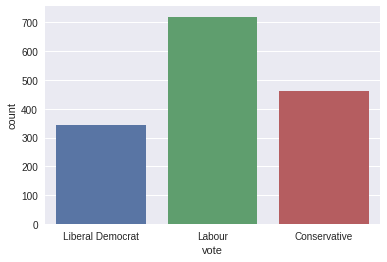

In [ ]:
sns.countplot(x="vote", data=beps);

The Labor party won that election. This might be the reason why it's more represented here!

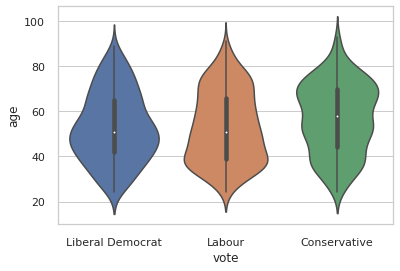

In [ ]:
sns.set(style="whitegrid")
sns.violinplot(x="vote", y="age", data=beps);

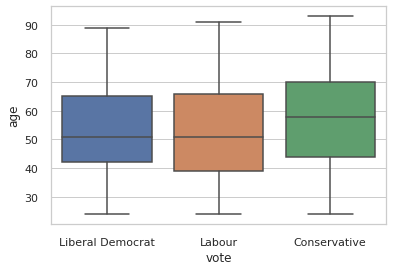

In [ ]:
sns.boxplot(x="vote", y="age", data=beps);

We can tell from the above two graphs that the Conservate party voter's typical age is higher than that of the two other parties

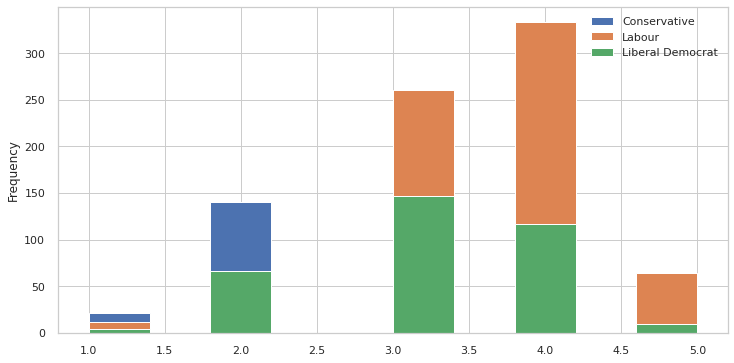

In [ ]:
beps.groupby('vote')['nat_cond'].plot.hist(legend=True, figsize=FIG_SIZE);

It seems like the Labor's party voters were happier with the national economic conditions than the others, followed by the Liberal Democrat's

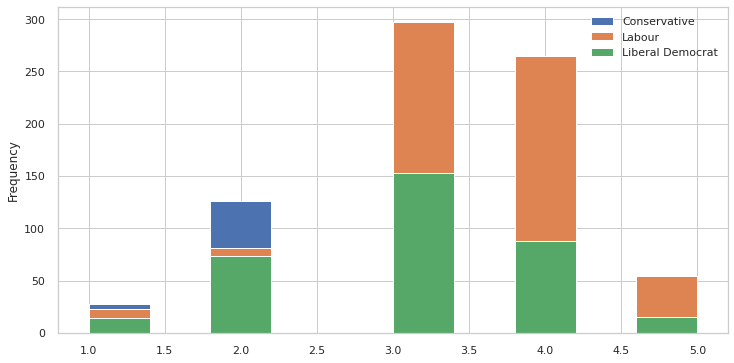

In [ ]:
beps.groupby('vote')['hhold_cond'].plot.hist(legend=True, figsize=FIG_SIZE);

The public attitude towards household economic conditions reflects that towards national economic conditions

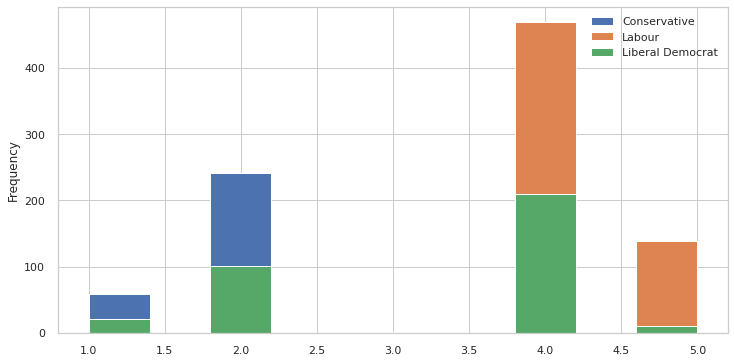

In [ ]:
beps.groupby('vote')['labor_lead_assmnt'].plot.hist(legend=True, figsize=FIG_SIZE);

It seems like the Labor's leader (i.e. Tony Blair) was just fine, but the voters might wanted more, because even among the Labor's voters there were way more 4s than 5s. Also, it seems like he was more popular among the Libral Democrats than the Conservatives.

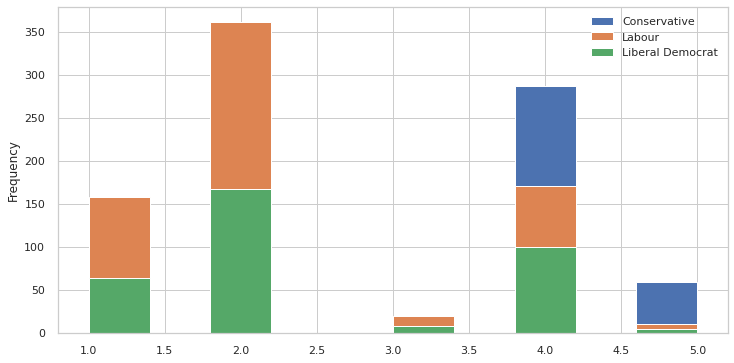

In [ ]:
beps.groupby('vote')['cons_lead_assmnt'].plot.hist(legend=True, figsize=FIG_SIZE);

It doesn't seem like the conservative's leader (i.e. John Major) was more popular among Labour's voters than the Labour's leader was among the Conservatives!
But the Liberal Democrats seemed more into the Labour's leader than the Conservative's leader.

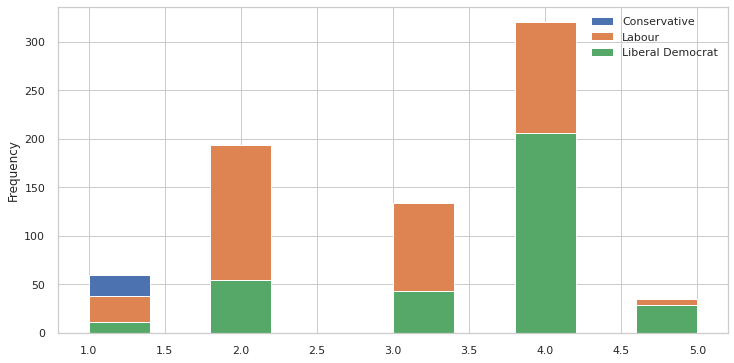

In [ ]:
beps.groupby('vote')['democ_lead_assmnt'].plot.hist(legend=True, figsize=FIG_SIZE);

The Liberal Democrat's leader (i.e. Paddy Ashdown) seemed just fine, but not so popular even among Liberal Democrats or the Labour's voters.
But it's obvious that the Conservatives didn't like him at all.

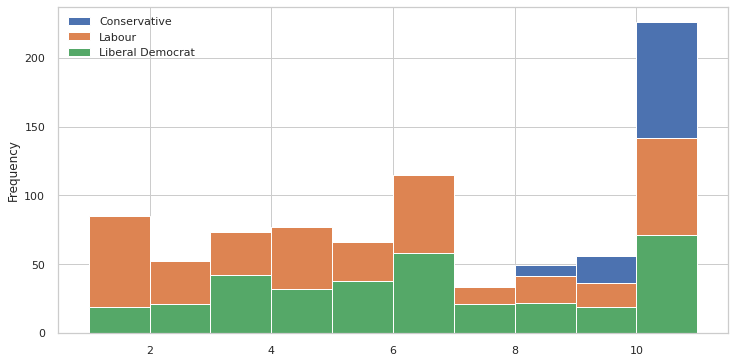

In [ ]:
beps.groupby('vote')['euro_intg_attud'].plot.hist(legend=True, figsize=FIG_SIZE);

The most prominent attitude was the Conservatives attitude! They seemed very Eurosceptic! 

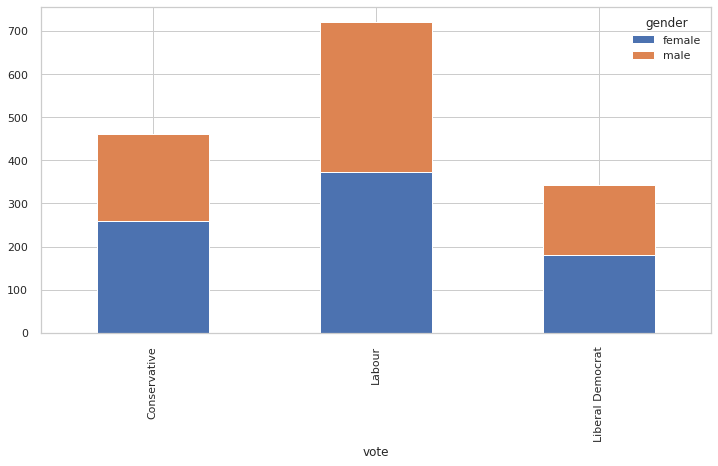

In [ ]:
beps.groupby(['vote', 'gender'])['vote'].count().unstack('gender').plot.bar(stacked=True, figsize=FIG_SIZE);

The number of female voters in almost all the parties was almost half the number of male voters!

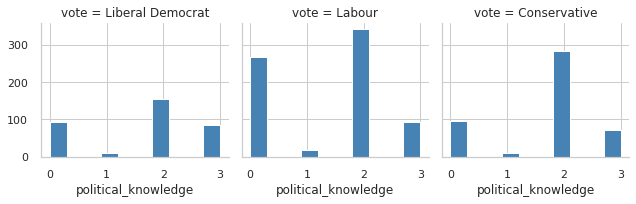

In [ ]:
g = sns.FacetGrid(beps, col="vote", margin_titles=True)
g.map(plt.hist, "political_knowledge", color="steelblue");

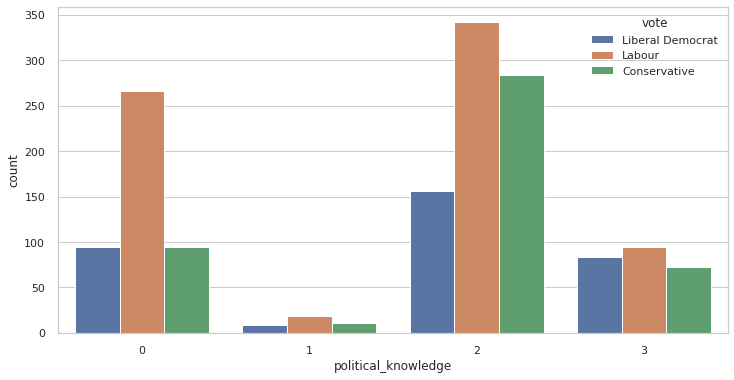

In [ ]:
plt.figure(figsize=FIG_SIZE)
sns.countplot(x='political_knowledge', hue='vote', data=beps);

We can vaguely say that the Conservatives tend to report higher knowledge of parties' positions on European integration than the other parties' voters tend to do!

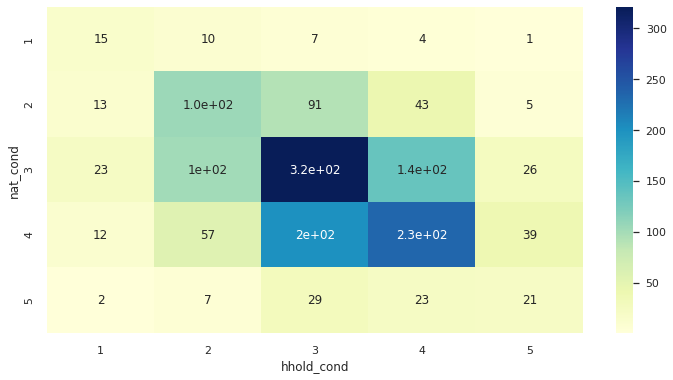

In [ ]:
nat_hhold = beps.groupby(["nat_cond", "hhold_cond"])["nat_cond"].count()
plt.figure(figsize=FIG_SIZE)
sns.heatmap(nat_hhold.unstack("hhold_cond"), annot=True, cmap="YlGnBu");

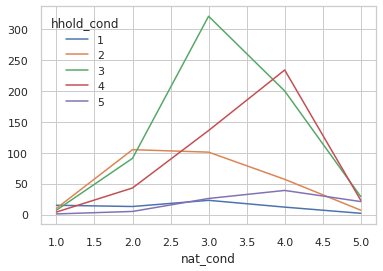

In [ ]:
nat_hhold.unstack().plot();

The relationhsip between voters' assessment of current national vs. household economic conditions is not linear! It's more like a bell shape skewed to the right. Voters were half-half satisfied about both!

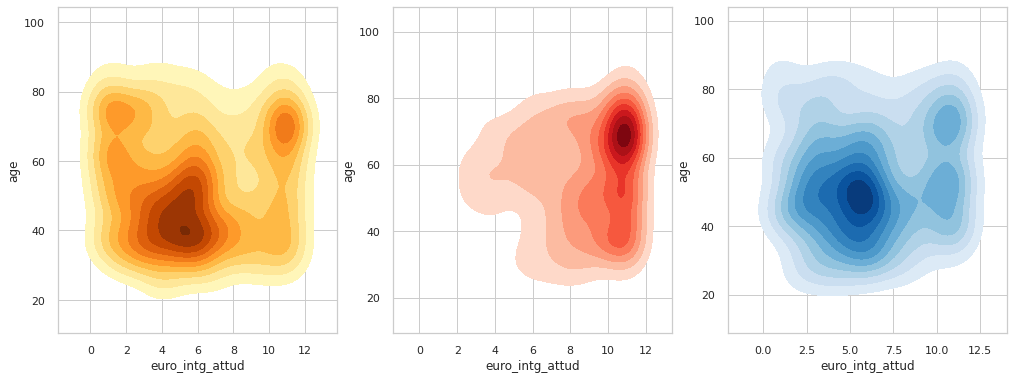

In [ ]:
plt.figure(figsize=(17, 6))
vote_lab = beps.loc[beps.vote == 'Labour']
vote_cons = beps.loc[beps.vote == 'Conservative']
vote_democ = beps.loc[beps.vote == 'Liberal Democrat']
plt.subplot(131)
sns.kdeplot(vote_lab['euro_intg_attud'], vote_lab['age'], cmap="YlOrBr", shade=True, shade_lowest=False)
plt.subplot(132)
sns.kdeplot(vote_cons['euro_intg_attud'], vote_cons['age'], cmap="Reds", shade=True, shade_lowest=False)
plt.subplot(133)
sns.kdeplot(vote_democ['euro_intg_attud'], vote_democ['age'], cmap="Blues", shade=True, shade_lowest=False);

The trend of older and more Eurosceptic Conservatives is obvious once more!

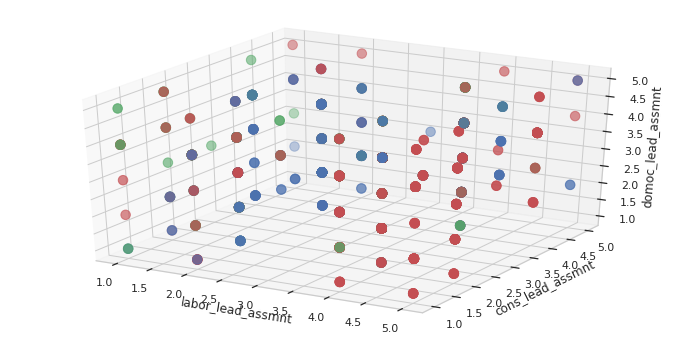

In [ ]:
fig = plt.figure(figsize=FIG_SIZE)
ax = fig.add_subplot(111, projection='3d')
beps_c = beps['vote'].map({'Labour':'r', 'Conservative':'b', 'Liberal Democrat':'g'})
ax.scatter(beps['labor_lead_assmnt'], beps['cons_lead_assmnt'], beps['democ_lead_assmnt'], s = 90, c=beps_c)
ax.set_xlabel('labor_lead_assmnt')
ax.set_ylabel('cons_lead_assmnt')
ax.set_zlabel('domoc_lead_assmnt')
plt.show()

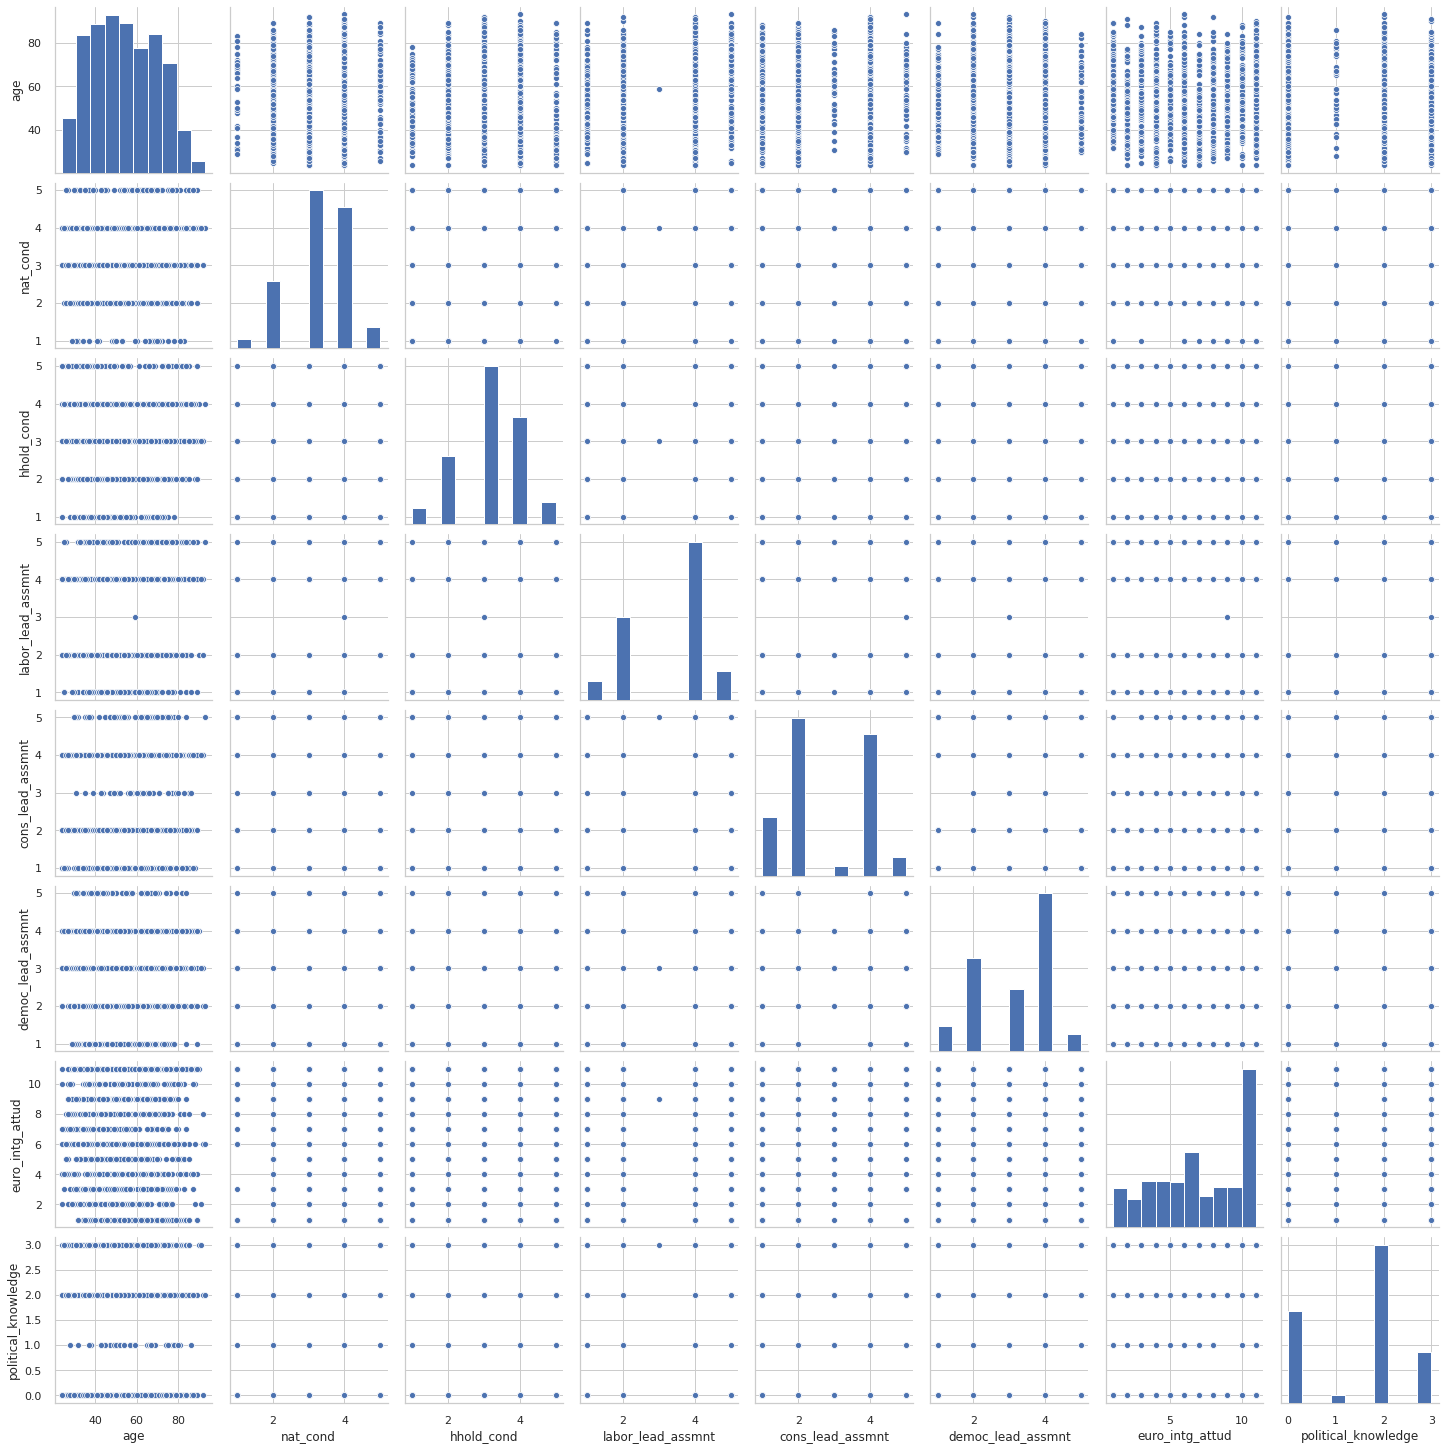

In [ ]:
sns.pairplot(beps[['age', 'nat_cond', 'hhold_cond', 'labor_lead_assmnt', 'cons_lead_assmnt', 'democ_lead_assmnt', 'euro_intg_attud', 'political_knowledge']]);

There is no **linear** correlation between any pair of variables! Even between variables like age and attitudes toward European integration for example, or age and political knowledge!

# Model Selection

In [ ]:
#changing gender column to 1 =female 0=male
beps.gender.replace(['female','male'],[1,0],inplace=True)
beps.vote.replace(['Labour','Conservative','Liberal Democrat'],[0,1,2], inplace=True)

In [ ]:
#Working on models
# Separating target columns
X = beps.drop('vote', axis='columns')
y = beps.vote

In [ ]:
#Will train with (X_train,y_train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 7)

In [ ]:
#f1_scorer for the gridSearch
f1_scorer = make_scorer(f1_score, average='micro')

In [ ]:
len(X_train)

1220

In [ ]:
len(X_test)

305

## Helper Functions

In [ ]:
#Method for ploting learning curve and Validation Curve
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")
    
    #plot Validation curve
    
    param_range = np.logspace(-6, -1, 5)
    trainVC_scores, testVC_scores = validation_curve(
        estimator, X, y, param_name="gamma", param_range=param_range,
        scoring="accuracy", n_jobs=1)
    trainVC_scores_mean = np.mean(trainVC_scores, axis=1)
    trainVC_scores_std = np.std(trainVC_scores, axis=1)
    testVC_scores_mean = np.mean(testVC_scores, axis=1)
    testVC_scores_std = np.std(testVC_scores, axis=1)

    plt.title("Validation Curve with SVM")
    plt.xlabel(r"$\gamma$")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, trainVC_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, trainVC_scores_mean - trainVC_scores_std,
                     trainVC_scores_mean + trainVC_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, testVC_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, testVC_scores_mean - testVC_scores_std,
                     testVC_scores_mean + testVC_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")

    return plt


In [ ]:
#Compare the testing data and prediction results by heatmap
def plot_confusion_matrix(y_test, y_preds):
    cm = confusion_matrix(y_test, y_preds)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm,annot=True,fmt='d',cmap="Blues",linewidths=.08)
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    plt.show()
    print("Classification Report")
    print(classification_report(y_test, y_preds))

In [ ]:
#Method for ploting learning curve and Validation Curve
def learningPlot_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(20, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt


In [ ]:
#Validation Curve
def validationPlot_curve(estimator, title, X, y,param,paramRange, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(20, 5))

    if ylim is not None:
        axes[0].set_ylim(*ylim)

    #plot Validation curve
    
    param_range = paramRange
    #np.logspace(-6, -1, 5)
    trainVC_scores, testVC_scores = validation_curve(
        estimator, X, y, param_name=param, param_range=param_range,
        scoring="accuracy", n_jobs=1)
    trainVC_scores_mean = np.mean(trainVC_scores, axis=1)
    trainVC_scores_std = np.std(trainVC_scores, axis=1)
    testVC_scores_mean = np.mean(testVC_scores, axis=1)
    testVC_scores_std = np.std(testVC_scores, axis=1)

    plt.title("Validation Curve")
    plt.xlabel(r"$\gamma$")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, trainVC_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, trainVC_scores_mean - trainVC_scores_std,
                     trainVC_scores_mean + trainVC_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, testVC_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, testVC_scores_mean - testVC_scores_std,
                     testVC_scores_mean + testVC_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")

    return plt


In [ ]:
def plot_curves(model, param_name, param_range):
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=7)
    validationPlot_curve(model, title, X, y,param_name,param_range,cv=cv, n_jobs=4)
    plt.show()
    learningPlot_curve(model, title, X, y,cv=cv, n_jobs=4)
    plt.show()

## Support Vector Machine Model (SVM) Analysis

In [ ]:
#Creating model
model = SVC()

In [ ]:
model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
model.score(X_test, y_test)

0.639344262295082

In [ ]:
#HyperParameter Tuning
param_grid = {'C': [1,50,100], 
              'gamma': [0.1,0.01,0.001,'scale'],
              'kernel': ['rbf','linear']}


In [ ]:
grid = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    cv=5,
    return_train_score=False,
    scoring=f1_scorer, 
    n_jobs=-1,
    verbose=2)
svm_grid=grid.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 11.5min finished


In [ ]:
svc_best_params = grid.best_params_

In [ ]:
grid.best_score_

0.6680327868852459

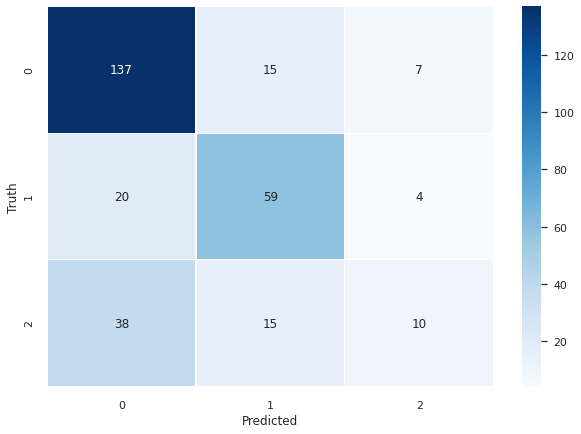

Classification Report
              precision    recall  f1-score   support

           0       0.70      0.86      0.77       159
           1       0.66      0.71      0.69        83
           2       0.48      0.16      0.24        63

    accuracy                           0.68       305
   macro avg       0.61      0.58      0.57       305
weighted avg       0.65      0.68      0.64       305



In [ ]:
grid_predictions = grid.predict(X_test)
plot_confusion_matrix(y_test, grid_predictions)

In [ ]:
# Learn to predict each class against the other
#ROC curve using the best params found in gridSearch
classifier = OneVsRestClassifier(SVC(C=100,kernel='rbf', probability=True,
                                 gamma='scale'))

In [ ]:
#Generating new yscore with the binarize data
svm_y_score = classifier.fit(X_train, y_train).decision_function(X_test)

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 15))
title = r"Learning Curves (SVM, RBF kernel, scale)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator =SVC(**svc_best_params)
plot_learning_curve(estimator, title, X, y, axes=axes,
                    cv=cv, n_jobs=4)

plt.show()

From the learning curve we can see that as the dataset is increacing the training accuracy is decreasing exponentially ,while the cross-validation score is increasing until they both reaches a point where they start converging to a lower value. We can conclude that our dataset is really complexe and won't benefit from adding more dataset.
From the validation curve

## Random Forest Model Analysis

In [ ]:
param_grid = {'n_estimators': [10, 100, 150, 200, 250, 300], 
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'max_features': [2, 4, 5, 6, 7, 9]              
              }

In [ ]:
#Using GridSearchCV for HPTuning
grid = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    cv=5,
    return_train_score=False,
    scoring=make_scorer(f1_score, average='micro'), 
    n_jobs=-1,
    verbose=2)

In [ ]:
rf_grid = grid.fit(X_train, y_train)

In [ ]:
rf_y_score = rf_grid.predict_proba(X_test)


In [ ]:
#Find Best Estimator
rf_best_params = rf_grid.best_params_ 
rf_best_est = rf_grid.best_estimator_
print("Best estimator:")
print(rf_best_est)

Best estimator:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [ ]:
rf_grid_predictions = rf_best_est.predict(X_test)
plot_confusion_matrix(y_test, rf_grid_predictions)

In [ ]:
#Importance  feature List: labor_lead_assmnt is the most importance 
feature_list = list(X)
feature_imp= pd.Series(rf_best_est.feature_importances_,index = feature_list).sort_values(ascending = False)
print(feature_imp)

In [ ]:
n_estimators = [10, 30, 50, 70, 100, 150, 200, 250, 300, 350]
max_depths = [2, 3, 4, 5, 6, 7, 8, 9]
acc_scores = []
val_scores = []
for mx_dep in max_depths:
    model_randomForest = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=mx_dep, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
    model_randomForest.fit(X_train,y_train)
    acc_scores.append(100 * (1 - model_randomForest.score(X_train, y_train)))
    preds = model_randomForest.predict(X_test)
    val_scores.append(100 * (1 - accuracy_score(y_test, preds)))

In [ ]:
plt.style.use('seaborn')
plt.plot(max_depths, acc_scores, label = 'Training error')
plt.plot(max_depths, val_scores, label = 'Validation error')
plt.ylabel('Error', fontsize = 14)
plt.xlabel('Max Depth', fontsize = 14)
plt.title('Learning curves for a Random Forest model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,100)

In [ ]:
best_rf = RandomForestClassifier(**rf_best_params)

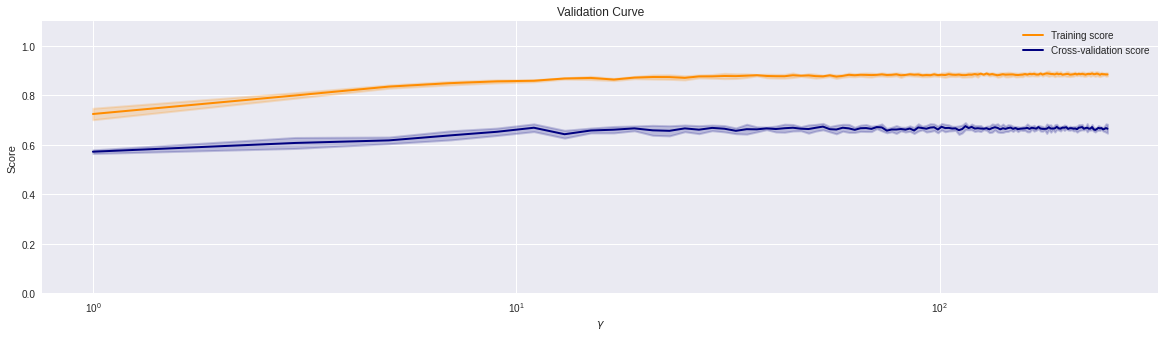

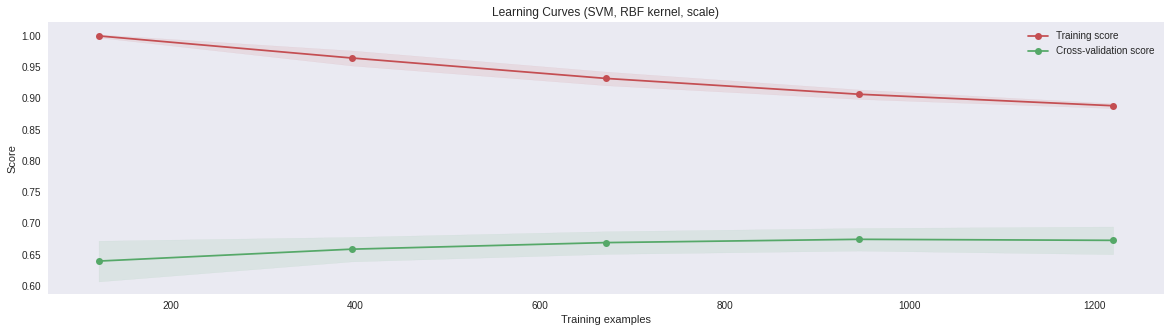

In [85]:
param_range = np.arange(1, 250, 2)
plot_curves(best_rf, "n_estimators", param_range)

## Multi-layer Perceptron Classifier (MLP) Model Analsysis

In [86]:
# Parameter tuning
from sklearn.neural_network import MLPClassifier
parameters = {
    'hidden_layer_sizes': [(100,), (200,), (300, ), (100, 2), (200, 2)], 
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.001, 0.0001, 10, 100],
    'activation': ['relu'],
    'learning_rate': ['adaptive']
}
                      
clf = GridSearchCV(estimator=MLPClassifier(max_iter=30000), param_grid=parameters, cv=5, scoring=f1_scorer, n_jobs=-1, verbose=2) 

In [87]:
mlp_model = clf.fit(X_train, y_train)
# mlp_y_score = mlp_model.decision_function(X_test)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 12.2min finished


In [88]:
print(clf.best_score_)
print(clf.best_params_)
mlp_best_params = clf.best_params_ 

0.6827868852459016
{'activation': 'relu', 'alpha': 10, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}


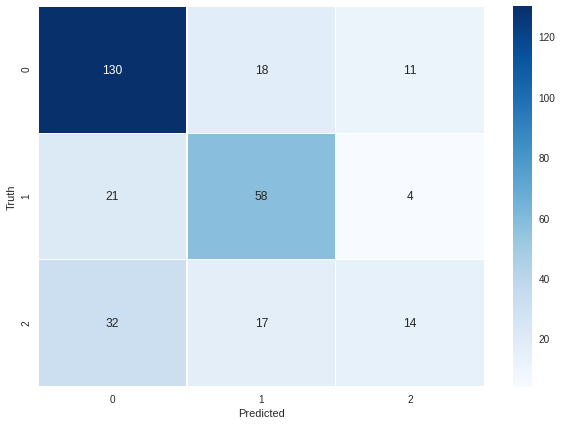

Classification Report
              precision    recall  f1-score   support

           0       0.71      0.82      0.76       159
           1       0.62      0.70      0.66        83
           2       0.48      0.22      0.30        63

    accuracy                           0.66       305
   macro avg       0.61      0.58      0.57       305
weighted avg       0.64      0.66      0.64       305



In [89]:
# confusion matrix
predictions = mlp_model.predict(X_test)
plot_confusion_matrix(y_test, predictions)

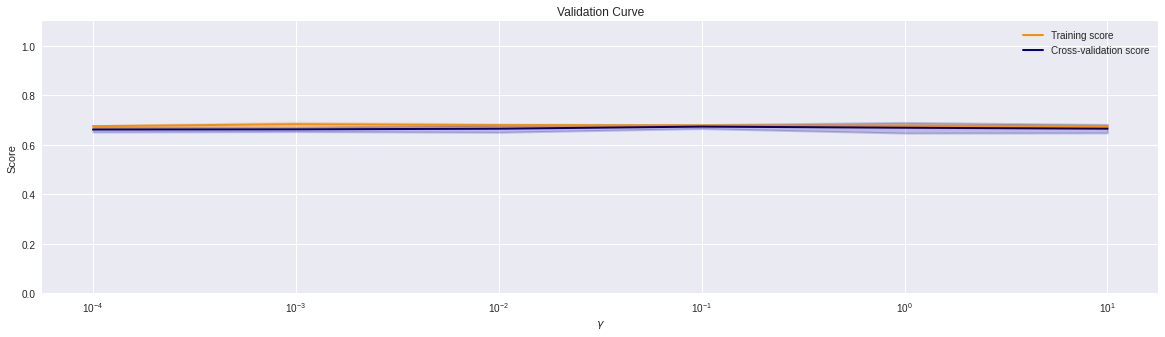

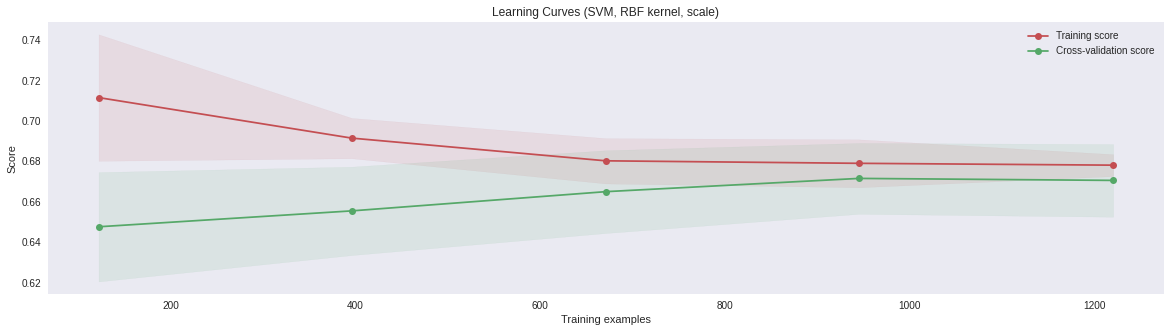

In [90]:
best_mlp = MLPClassifier(**mlp_best_params)
param_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
plot_curves(best_mlp, "alpha", param_range)

## Logistical Regression Model Analysis

In [91]:
# basic
clf = LogisticRegressionCV(cv = 5).fit(X_train, y_train)
print(clf)
print("Train Error: ", clf.score(X_train, y_train))
print("Test Error: ", clf.score(X_test, y_test))

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)
Train Error:  0.6778688524590164
Test Error:  0.6754098360655738


In [92]:
# first
clf = LogisticRegression()
acc_scorer = make_scorer(accuracy_score)
parameters = {'C': [0.01, 0.03, 0.05, 0.07],
              'solver': ['newton-cg', 'lbfgs']}

# Grid Search (use the default 5-fold cross validation)
grid_obj = GridSearchCV(clf, parameters, acc_scorer, cv = 5)
grid_obj = grid_obj.fit(X_train, y_train)
# logit_y_score = grid_obj.decision_function(X_test)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_
logit_best_params = grid_obj.best_params_ 
print(clf)

print("Best Score: ", grid_obj.best_score_)
print("Train Error: ", clf.score(X_train, y_train))
print("Test Error: ", clf.score(X_test, y_test))

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best Score:  0.6762295081967213
Train Error:  0.6836065573770492
Test Error:  0.6754098360655738


In [93]:
# second
clf = LogisticRegressionCV(cv = 5)

acc_scorer = make_scorer(accuracy_score)
parameters = {'Cs': [5, 10, 15],
              'solver': ['newton-cg', 'lbfgs']}

# Grid Search (use the default 5-fold cross validation)
grid_obj = GridSearchCV(clf, parameters, acc_scorer, cv = 10)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_
print(clf)

print("Best Score: ", grid_obj.best_score_)
print("Train Error: ", clf.score(X_train, y_train))
print("Test Error: ", clf.score(X_test, y_test))

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='newton-cg', tol=0.0001, verbose=0)
Best Score:  0.6688524590163935
Train Error:  0.6819672131147541
Test Error:  0.6754098360655738


In [94]:
# logit
max_iter_values = [1, 5, 10, 20, 50, 100, 150, 200]

acc_scores = []
val_scores = []
for x in max_iter_values:
    model = LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True, 
                              intercept_scaling=1, l1_ratio=None, max_iter=x,
                              multi_class='auto', n_jobs=None, penalty='l2',
                              random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                              warm_start=False)
    
    model.fit(X_train, y_train)
    acc_scores.append(100 * (1 - model.score(X_train, y_train)))
    preds = model.predict(X_test)
    val_scores.append(100 * (1 - accuracy_score(y_test, preds)))

(0.0, 100.0)

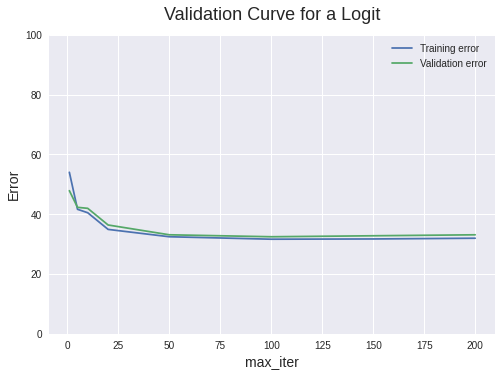

In [95]:
# using?
darw_acc = max_iter_values

plt.style.use('seaborn')
plt.plot(darw_acc, acc_scores, label = 'Training error')
plt.plot(darw_acc, val_scores, label = 'Validation error')
plt.ylabel('Error', fontsize = 14)
plt.xlabel('max_iter', fontsize = 14)
plt.title('Validation Curve for a Logit', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,100)

In [96]:
# Method for ploting learning curve and Validation Curve
def plot_learning_curve_2(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(20, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

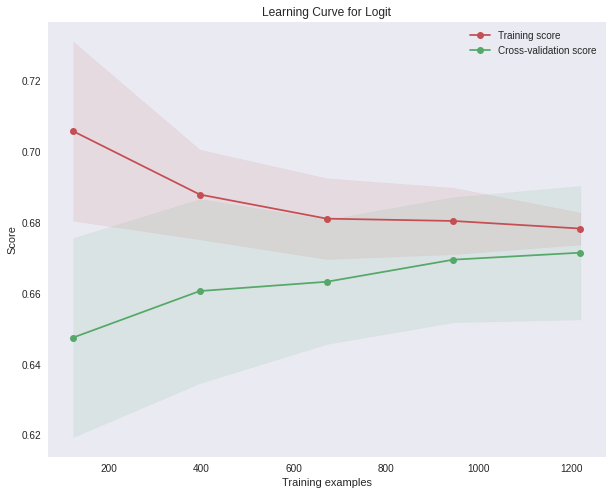

In [97]:
# Logit
fig, axes = plt.subplots(1, 1, figsize=(10,8))
title = "Learning Curve for Logit"

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=7)

estimator = LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
                   
plot_learning_curve_2(estimator, title, X, y, cv = cv, axes=axes)

plt.show()

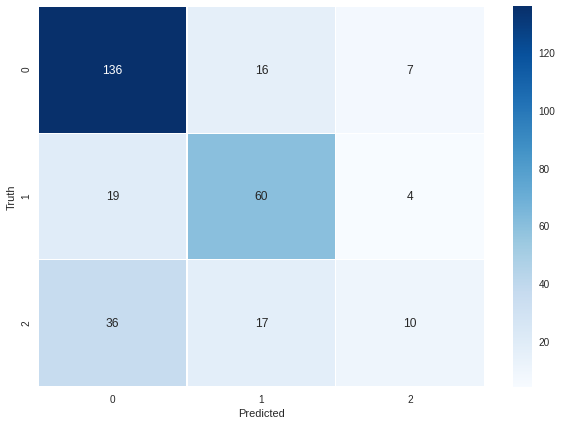

Classification Report
              precision    recall  f1-score   support

           0       0.71      0.86      0.78       159
           1       0.65      0.72      0.68        83
           2       0.48      0.16      0.24        63

    accuracy                           0.68       305
   macro avg       0.61      0.58      0.57       305
weighted avg       0.65      0.68      0.64       305



In [98]:
# confusion matrix
predictions = clf.predict(X_test)
plot_confusion_matrix(y_test, predictions)

## K-Nearest Neigbor Model Analysis

In [99]:
# Parameter tuning
from sklearn.neighbors import KNeighborsClassifier
parameters = {
    'n_neighbors': [1, 2, 5, 10, 15, 20, 25, 30], 
    'weights': ['uniform', 'distance'],
}
                      
clf = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=parameters, cv=5, scoring=f1_scorer, n_jobs=-1, verbose=2) 

In [100]:
knn_model = clf.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.9s finished


In [101]:
print(clf.best_score_)
print(clf.best_params_)
knn_best_params = clf.best_params_ 

0.6360655737704918
{'n_neighbors': 25, 'weights': 'uniform'}


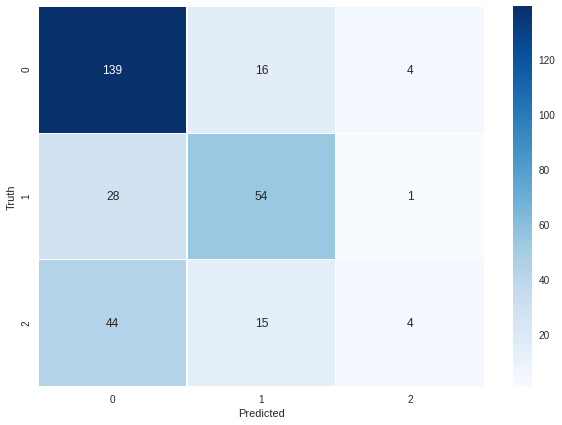

Classification Report
              precision    recall  f1-score   support

           0       0.66      0.87      0.75       159
           1       0.64      0.65      0.64        83
           2       0.44      0.06      0.11        63

    accuracy                           0.65       305
   macro avg       0.58      0.53      0.50       305
weighted avg       0.61      0.65      0.59       305



In [102]:
# confusion matrix
predictions = knn_model.predict(X_test)
plot_confusion_matrix(y_test, predictions)

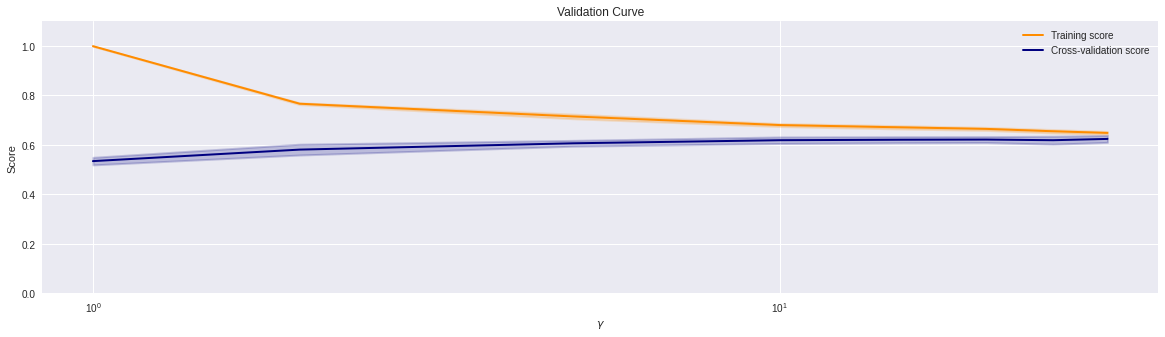

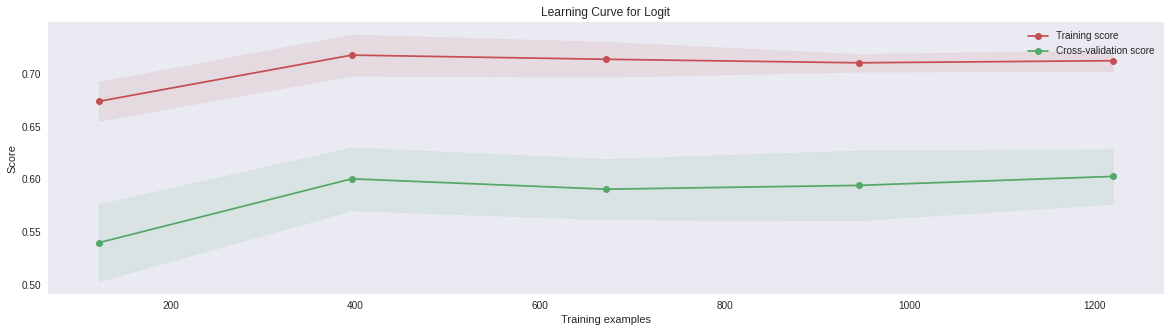

In [103]:
best_knn = KNeighborsClassifier()
param_range = np.array([1, 2, 5, 10, 15, 20, 25, 30])
plot_curves(best_knn, "n_neighbors", param_range)

## Naive Bayes Model Analysis

In [104]:
# third
clf = GaussianNB()
acc_scorer = make_scorer(accuracy_score)
parameters = {'var_smoothing': [1e-10, 1e-09, 1e-08]}

# Grid Search (use the default 5-fold cross validation)
grid_obj = GridSearchCV(clf, parameters, acc_scorer, cv = 5)
grid_obj = grid_obj.fit(X_train, y_train)
# naive_y_score = grid_obj.decision_function(X_test)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_
naive_best_params = grid_obj.best_params_ 
print(clf)

print("Best Score: ", grid_obj.best_score_)
print("Train Error: ", clf.score(X_train, y_train))
print("Test Error: ", clf.score(X_test, y_test))

GaussianNB(priors=None, var_smoothing=1e-10)
Best Score:  0.6713114754098362
Train Error:  0.6762295081967213
Test Error:  0.659016393442623


In [105]:
# naive bayes
var_smoothing_values = [2, 1, 0.5, 0.3, 1e-1, 1e-3, 1e-5, 1e-7, 1e-9, 1e-10, 1e-11]

acc_scores = []
val_scores = []
for x in var_smoothing_values:
    model = GaussianNB(priors=None, var_smoothing=x)
    
    model.fit(X_train, y_train)
    acc_scores.append(100 * (1 - model.score(X_train, y_train)))
    preds = model.predict(X_test)
    val_scores.append(100 * (1 - accuracy_score(y_test, preds)))

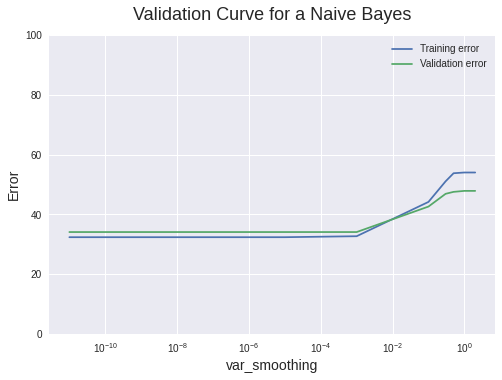

In [106]:
# using?
darw_acc = var_smoothing_values

plt.style.use('seaborn')
plt.plot(darw_acc, acc_scores, label = 'Training error')
plt.plot(darw_acc, val_scores, label = 'Validation error')
plt.ylabel('Error', fontsize = 14)
plt.xlabel('var_smoothing', fontsize = 14)
plt.title('Validation Curve for a Naive Bayes', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0, 100)
plt.xscale("log")

In [107]:
# Method for ploting learning curve and Validation Curve
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(20, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

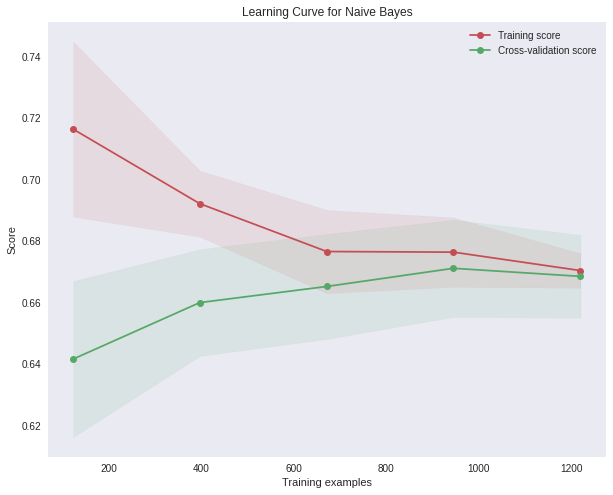

In [108]:
# Naive Bayes
fig, axes = plt.subplots(1, 1, figsize=(10,8))
title = "Learning Curve for Naive Bayes"

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=7)

estimator = GaussianNB(priors=None, var_smoothing=1e-10)
                   
plot_learning_curve(estimator, title, X, y, cv = cv, axes=axes)

plt.show()

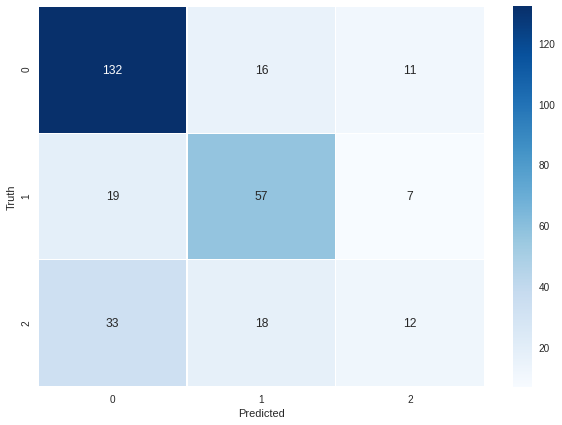

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.83      0.77       159
           1       0.63      0.69      0.66        83
           2       0.40      0.19      0.26        63

    accuracy                           0.66       305
   macro avg       0.58      0.57      0.56       305
weighted avg       0.63      0.66      0.63       305



In [109]:
# confusion matrix
predictions = clf.predict(X_test)
plot_confusion_matrix(y_test, predictions)

###One-vs-Rest

In [110]:
nb_ovr = GaussianNB()

In [111]:
ovr_clf = OneVsRestClassifier(nb_ovr)
ovr_clf.fit(X_train, y_train);

In [112]:
print("OVR Training Accuracy: %.4f" % ovr_clf.score(X_train, y_train))
print("OVR Validation Accuracy: %.4f" % ovr_clf.score(X_test, y_test))

OVR Training Accuracy: 0.6721
OVR Validation Accuracy: 0.6623


###One-vs-One

In [113]:
nb_ovo = GaussianNB()
ovo_clf = OneVsOneClassifier(nb_ovo)
ovo_clf.fit(X_train, y_train);

In [114]:
print("OVO Training Accuracy: %.4f" % ovo_clf.score(X_train, y_train))
print("OVO Validation Accuracy: %.4f" % ovo_clf.score(X_test, y_test))

OVO Training Accuracy: 0.6762
OVO Validation Accuracy: 0.6590


###Manual One-vs-One

In [115]:
nb_lab_con = GaussianNB()

In [116]:
beps_lab_con = beps[beps.vote != 2]
y_lab_con = beps_lab_con.vote
X_lab_con = beps_lab_con.drop('vote', axis='columns')

In [117]:
X_lab_con_train, X_lab_con_test, y_lab_con_train, y_lab_con_test = train_test_split(X_lab_con, y_lab_con, test_size=0.2)

In [118]:
nb_lab_con.fit(X_lab_con_train, y_lab_con_train);

In [119]:
print("Labour vs. Conservative Training Accuracy: %.4f" % nb_lab_con.score(X_lab_con_train, y_lab_con_train))
print("Labour vs. Conservative Validation Accuracy: %.4f" % nb_lab_con.score(X_lab_con_test, y_lab_con_test))

Labour vs. Conservative Training Accuracy: 0.8381
Labour vs. Conservative Validation Accuracy: 0.8776


In [120]:
nb_lab_lib = GaussianNB()

In [121]:
beps_lab_lib = beps[beps.vote != 1]
y_lab_lib = beps_lab_lib.vote
X_lab_lib = beps_lab_lib.drop('vote', axis='columns')

In [122]:
X_lab_lib_train, X_lab_lib_test, y_lab_lib_train, y_lab_lib_test = train_test_split(X_lab_lib, y_lab_lib, test_size=0.2)

In [123]:
nb_lab_lib.fit(X_lab_lib_train, y_lab_lib_train);

In [124]:
print("Labour vs. Libral Democrat Training Accuracy: %.4f" % nb_lab_lib.score(X_lab_lib_train, y_lab_lib_train))
print("Labour vs. Libral Democrat Validation Accuracy: %.4f" % nb_lab_lib.score(X_lab_lib_test, y_lab_lib_test))

Labour vs. Libral Democrat Training Accuracy: 0.7129
Labour vs. Libral Democrat Validation Accuracy: 0.6854


In [125]:
nb_con_lib = GaussianNB()

In [126]:
beps_con_lib = beps[beps.vote != 0]
y_con_lib = beps_con_lib.vote
X_con_lib = beps_con_lib.drop('vote', axis='columns')

In [127]:
X_con_lib_train, X_con_lib_test, y_con_lib_train, y_con_lib_test = train_test_split(X_con_lib, y_con_lib, test_size=0.2)

In [128]:
nb_con_lib.fit(X_con_lib_train, y_con_lib_train);

In [129]:
print("Conservative vs. Libral Democrat Training Accuracy: %.4f" % nb_con_lib.score(X_con_lib_train, y_con_lib_train))
print("Conservative vs. Libral Democrat Validation Accuracy: %.4f" % nb_con_lib.score(X_con_lib_test, y_con_lib_test))

Conservative vs. Libral Democrat Training Accuracy: 0.7935
Conservative vs. Libral Democrat Validation Accuracy: 0.7578


In [130]:
pred_lab_con = nb_lab_con.predict(X_test)
pred_lab_lib = nb_lab_lib.predict(X_test)
pred_con_lib = nb_con_lib.predict(X_test)

In [131]:
pred = []
for i in range(y_test.shape[0]):
    if pred_lab_con[i] == pred_lab_lib[i] or pred_lab_con[i] == pred_con_lib[i]:
        pred.append(pred_lab_con[i])
    elif pred_lab_lib[i] == pred_con_lib[i]:
        pred.append(pred_lab_lib[i])
    else:
        pred.append(pred_con_lib[i])

In [132]:
accuracy_score(pred, y_test)

0.6622950819672131

## Ensemble Model Analysis

In [133]:
# list best models
best_models = [
               SVC(**svc_best_params), 
               MLPClassifier(**mlp_best_params),
               RandomForestClassifier(**rf_best_params),
               KNeighborsClassifier(**knn_best_params),
               LogisticalRegression(**logit_best_params),
               GaussianNB(**naive_best_params)
               
]
                             
names = [
         'SVC',
         'MLP',
         'RF',
         'KNN',
         'LOGIT',
         'NAIVE'
]

ensemble_models = list(zip(names, best_models))

NameError: ignored

### Stacking Approach

Stacked generalization consists in stacking the output of individual estimator and use a classifier to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

clf = StackingClassifier(estimators=ensemble_models, final_estimator=LogisticRegression())

In [ ]:
ens_model = clf.fit(X_train, y_train)

In [ ]:
print(clf.score(X_test, y_test))

In [ ]:
# confusion matrix
predictions = ens_model.predict(X_test)
plot_confusion_matrix(y_test, predictions)

### Bagging Approach


In [ ]:
from sklearn.ensemble import BaggingClassifier

parameters = {
    'max_samples': [0.5, 0.6, 0.8, 1.0],
    'max_features': [0.5, 0.6, 0.8, 1.0]
}

bagging_models = []

for name, model in ensemble_models:
  m = GridSearchCV(estimator=BaggingClassifier(model), param_grid=parameters, cv=5, scoring=f1_scorer, n_jobs=-1, verbose=2)
  m.fit(X_train, y_train)
  bagging_models.append(m)

In [ ]:
train_scores = []

for model in bagging_models:
  train_scores.append(m.best_score_)
print(train_scores)
test_scores = []
for model in bagging_models:
  sc = model.best_estimator_.score(X_test, y_test)
  test_scores.append(sc)
print(test_scores)

In [ ]:
model_scores = list(zip(names, train_scores))
for name, score in model_scores:
  print("Train score for %s: %f" % (name,score))

model_scores = list(zip(names, test_scores))
for name, score in model_scores:
  print("Test score for %s: %f" % (name,score))

### Boosting Approach

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

parameters = {
    'n_estimators': [50, 100, 150, 200]
}

grid = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=parameters, cv=5, scoring=f1_scorer, n_jobs=-1, verbose=2) 

In [ ]:
grid.fit(X_train, y_train)

In [ ]:
grid.best_score_

In [ ]:
grid.best_estimator_.score(X_test, y_test)

### Voting Approach

In [ ]:
from sklearn.ensemble import VotingClassifier

clf = VotingClassifier(estimators=ensemble_models, voting='hard')
clf.fit(X_train, y_train)
print("Test scores: %f" % clf.score(X_test, y_test))

## AutoML

In [ ]:
pipeline_optimizer = TPOTClassifier(generations=5, cv=5, random_state=42, verbosity=2)

In [ ]:
pipeline_optimizer.fit(X_train, y_train)

In [ ]:
print("AutoML Training Accuracy: %.4f" % pipeline_optimizer.score(X_train, y_train))
print("AutoML Validation Accuracy: %.4f" % pipeline_optimizer.score(X_test, y_test))

# AUC

In [ ]:
auc_y = label_binarize(y_test, classes=[0, 1, 2])
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'yellow', 'pink', 'purple'])

In [ ]:
def auc_curve(model, y_test, color, name):
    clf = OneVsRestClassifier(model)
    clf.fit(X_train, y_train)
    if hasattr(clf, "decision_function"):
        y_score = clf.decision_function(X_test)
    else:
        y_score = clf.predict_proba(X_test)
    
    n_classes=3
    
    # Compute ROC curve for the model with the best paramater
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.plot(fpr[2], tpr[2], color=color,lw=lw, label='%s ROC curve (area = %0.2f)' % (name, roc_auc[2]))

In [ ]:
auc_models = list(zip(colors, ensemble_models))

In [ ]:
# Plot
plt.figure(figsize=(20, 10))
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

for color, (name, model) in auc_models:
  auc_curve(model, auc_y, color, name)


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

plt.show()

# References

*   https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/
*   https://epistasislab.github.io/tpot/using/
*   https://scikit-learn.org
*   https://github.com/corymaklin/svm/blob/master/svm.ipynb
*   https://scikit-learn.org/stable/auto_examples/datasets/plot_random_dataset.html
*   https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
*   https://stats.stackexchange.com/questions/437072/use-f1-score-in-gridsearchcv
*   https://matplotlib.org/3.1.1/tutorials/toolkits/mplot3d.html
*   https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
*   https://docs.w3cub.com/scikit_learn/auto_examples/model_selection/plot_validation_curve/
*   https://matplotlib.org/3.1.1/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.html
*   https://pythonprogramming.net/matplotlib-3d-scatterplot-tutorial/
*   https://stackoverflow.com/questions/55375515/change-marker-color-in-3d-scatter-plot-based-on-condition
*   https://stackoverflow.com/questions/19451400/matplotlib-scatter-marker-size
*   https://github.com/dataprofessor/code/blob/master/python/ROC_curve.ipynb


